In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

! kaggle datasets download -d devicharith/language-translation-englishfrench

! unzip /content/language-translation-englishfrench.zip

! rm /content/language-translation-englishfrench.zip

  0% 0.00/3.51M [00:00<?, ?B/s]
100% 3.51M/3.51M [00:00<00:00, 162MB/s]
Archive:  /content/language-translation-englishfrench.zip
  inflating: eng_-french.csv         


In [ ]:
import pandas as pd
import re
import numpy as np
import tensorflow as tf

In [ ]:
df = pd.read_csv("/content/eng_-french.csv")
df.rename(columns={'English words/sentences':'eng', 'French words/sentences':'fre'}, inplace=True)
df = df[:10000]
df['decode'] = df.fre.copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df.head(3)

,eng,fre,decode
0,Hi.,Salut!,Salut!
1,Run!,Cours !,Cours !
2,Run!,Courez !,Courez !


In [ ]:
df.eng = df.eng.apply(lambda x: " ".join( re.sub(r'[^\s\w]',' ',x.lower()).split() )  )
df.fre = df.fre.apply(lambda x: " ".join(re.sub(r'[^\s\w]',' ',x.lower()).split()) + " _END")
df.decode = df.decode.apply(lambda x: "START_ "+ " ".join(re.sub(r'[^\s\w]',' ',x.lower()).split()))

In [ ]:
df.head(3)

,eng,fre,decode
0,hi,salut _END,START_ salut
1,run,cours _END,START_ cours
2,run,courez _END,START_ courez


In [ ]:
def uniq_words(col) :
  a = 1
  map = {}
  for i in col :
    for j in i.split() :
      if j not in map.keys() :
        map[j] = a
        a = a+1
  return map

In [ ]:
fre_words_map = uniq_words(df.decode)
eng_words_map = uniq_words(df.eng)

fre_words_map['_END'] = len(fre_words_map)+1
fre_words_map[''] = 0
eng_words_map[''] = 0

In [ ]:
def num_2_words (word_2_num) :
  map = {}
  for i in word_2_num :
    map[word_2_num[i]] = i
  return map

In [ ]:
ind_2_fre_map = num_2_words(fre_words_map)

In [ ]:
def word_count(col) :
  return max([len(x.split()) for x in col])

In [ ]:
eng_len = word_count(df.eng)
fre_len = word_count(df.fre)

In [ ]:
test_case = 1000
eng_words = len(eng_words_map)
fre_words = len(fre_words_map)

In [ ]:
encoder_input = np.zeros((test_case,eng_len,eng_words))
decoder_input = np.zeros((test_case,fre_len,fre_words))
decoder_output = np.zeros((test_case,fre_len,fre_words))

In [ ]:
for i in range(test_case) :

  a = 0
  for j in df.eng.iloc[i].split() : 
    encoder_input[i][a][eng_words_map[j]] = 1
    a = a+1
  for j in range(a,eng_len):
    encoder_input[i][j][0] = 1

  a = 0
  for j in df.decode.iloc[i].split() : 
    decoder_input[i][a][fre_words_map[j]] = 1
    a = a+1
  for j in range(a,fre_len):
    decoder_input[i][j][0] = 1

  a = 0
  for j in df.fre.iloc[i].split() : 
    decoder_output[i][a][fre_words_map[j]] = 1
    a = a+1
  for j in range(a,fre_len):
    decoder_output[i][j][0] = 1

In [ ]:
lstm_units = 100

In [ ]:
encoder_layer_input = tf.keras.layers.Input(shape=(None, eng_words))
encoder_layer_lstm = tf.keras.layers.LSTM(lstm_units, return_state=True)
encoder_layer_output, encoder_layer_h, encoder_layer_c = encoder_layer_lstm(encoder_layer_input)
encoder_layer_states = [encoder_layer_h, encoder_layer_c]

decoder_layer_input = tf.keras.layers.Input(shape=(None, fre_words))
decoder_layer_lstm = tf.keras.layers.LSTM(lstm_units, return_state=True, return_sequences=True)
decoder_layer_output, _ , _ = decoder_layer_lstm(decoder_layer_input, initial_state = encoder_layer_states)

decoder_layer_dense = tf.keras.layers.Dense(fre_words, activation='softmax')
decoder_layer_dense_output = decoder_layer_dense(decoder_layer_output)

In [ ]:
model = tf.keras.Model(inputs=[encoder_layer_input, decoder_layer_input], outputs = decoder_layer_dense_output)
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, 2111)  0           []                               
                                ]                                                                 
                                                                                                  
 input_8 (InputLayer)           [(None, None, 4031)  0           []                               
                                ]                                                                 
                                                                                                  
 lstm_4 (LSTM)                  [(None, 100),        884800      ['input_7[0][0]']                
                                 (None, 100),                                               

In [ ]:
model.fit(
    x = [encoder_input, decoder_input],
    y = decoder_output,
    epochs = 1000
)

Epoch 1/1000
32/32 [==============================] - 3s 19ms/step - loss: 7.2188 - accuracy: 0.6443
Epoch 2/1000
32/32 [==============================] - 1s 16ms/step - loss: 2.2321 - accuracy: 0.7095
Epoch 3/1000
32/32 [==============================] - 1s 16ms/step - loss: 1.6886 - accuracy: 0.7095
Epoch 4/1000
32/32 [==============================] - 1s 16ms/step - loss: 1.5566 - accuracy: 0.7095
Epoch 5/1000
32/32 [==============================] - 1s 16ms/step - loss: 1.4830 - accuracy: 0.7165
Epoch 6/1000
32/32 [==============================] - 1s 16ms/step - loss: 1.4333 - accuracy: 0.7405
Epoch 7/1000
32/32 [==============================] - 1s 16ms/step - loss: 1.3962 - accuracy: 0.7573
Epoch 8/1000
32/32 [==============================] - 1s 16ms/step - loss: 1.3639 - accuracy: 0.7645
Epoch 9/1000
32/32 [==============================] - 0s 15ms/step - loss: 1.3386 - accuracy: 0.7686
Epoch 10/1000
32/32 [==============================] - 1s 16ms/step - loss: 1.3150 - accura

In [ ]:
encoder = tf.keras.Model(encoder_layer_input, encoder_layer_states)

In [ ]:
decoder_old_h = tf.keras.layers.Input(shape=(lstm_units))
decoder_old_c = tf.keras.layers.Input(shape=(lstm_units))
decoder_old_states = [decoder_old_h, decoder_old_c]

decoder_layer_output, decoder_h , decoder_c = decoder_layer_lstm(decoder_layer_input, initial_state = decoder_old_states)
decoder_output = decoder_layer_dense(decoder_layer_output)
decoder_states = [decoder_h, decoder_c]

decoder = tf.keras.Model([decoder_layer_input]+decoder_old_states, [decoder_output]+decoder_states)

In [ ]:
def get_prediction (ind) :
  encoder_pred_inp = np.array([encoder_input[ind]])
  encoder_pred_out = encoder.predict(encoder_pred_inp)

  decoder_pred_inp = np.zeros((1,1,fre_words))
  decoder_pred_inp[0][0][fre_words_map['START_']] = 1

  result = []

  for i in range(fre_len) :

    val,h,c = decoder.predict([decoder_pred_inp] + encoder_pred_out)
    encoder_pred_out = [h,c]

    val = np.argmax(val[0][0])

    decoder_pred_inp = np.zeros((1,1,fre_words))
    decoder_pred_inp[0][0][val] = 1
    
    result.append(ind_2_fre_map[val])

    if val==fre_words_map['_END'] :
      break

  return " ".join(result)

In [ ]:
a = 0
for i in range(100) :
  res = get_prediction(i)

  if df.fre.iloc[i]==res :
    a = a+1
  print(df.fre.iloc[i] ,'\t\t', res, '\t\t', df.fre.iloc[i]==res)

salut _END 		 salut _END 		 True
cours _END 		 cours _END 		 True
courez _END 		 cours _END 		 False
qui _END 		 qui _END 		 True
ça alors _END 		 ça alors _END 		 True
au feu _END 		 au feu _END 		 True
à l aide _END 		 à l aide _END 		 True
saute _END 		 saute _END 		 True
ça suffit _END 		 arrête toi _END 		 False
stop _END 		 arrête toi _END 		 False
arrête toi _END 		 arrête toi _END 		 True
attends _END 		 attendez _END 		 False
attendez _END 		 attendez _END 		 True
poursuis _END 		 poursuivez _END 		 False
continuez _END 		 poursuivez _END 		 False
poursuivez _END 		 poursuivez _END 		 True
bonjour _END 		 bonjour _END 		 True
salut _END 		 bonjour _END 		 False
je comprends _END 		 je comprends _END 		 True
j essaye _END 		 j essaye _END 		 True
j ai gagné _END 		 j ai gagné _END 		 True
je l ai emporté _END 		 j ai gagné _END 		 False
j ai gagné _END 		 j ai gagné _END 		 True
oh non _END 		 oh non _END 		 True
attaque _END 		 attaquez _END 		 False
attaquez _END 		 attaquez 

In [ ]:
a

50

In [ ]:
import random
result = []
for i in range(fre_len) :
  result.append(ind_2_fre_map[random.randint(0,fre_words)])
print(" ".join(result))

mal heure partie tombées réveille essayerons sourde affreux occupé


In [ ]:
inp = tf.keras.layers.Input(shape=(eng_sen), name='english input')
emb = tf.keras.layers.Embedding(input_dim=eng_vob, output_dim=encoder_emb_dim, input_length=eng_sen, name='encoder_embedding')(inp)

enc = tf.keras.layers.LSTM(20, return_sequences=True, return_state=True, name='encoder_1')
enc_out, state_h, state_c = enc(emb)
states = [state_h, state_c]

enc = tf.keras.layers.LSTM(20,return_sequences=True, return_state=True, name='encoder_2')
enc_out, state_h, state_c = enc(enc_out, initial_state=states)
states = [state_h, state_c]

enc = tf.keras.layers.LSTM(20,return_sequences=True, return_state=True, name='encoder_3')
enc_out, state_h, state_c = enc(enc_out, initial_state=states)
states = [state_h, state_c]

enc = tf.keras.layers.LSTM(20,return_sequences=True, return_state=True, name='encoder_4')
enc_out, state_h, state_c = enc(enc_out, initial_state=states)
states = [state_h, state_c]




inp2 = tf.keras.layers.Input(shape=(fre_sen), name='french input')
emb2 = tf.keras.layers.Embedding(input_dim=fre_vob, output_dim=decoder_emb_dim, input_length=fre_sen, name='decoder_embedding')(inp2)

dec = tf.keras.layers.LSTM(20,return_sequences=True, return_state=True, name='decoder_1')
out, state_h, state_c = dec(emb2, initial_state=states)
states = [state_h, state_c]

dec = tf.keras.layers.LSTM(20,return_sequences=True, return_state=True, name='decoder_2')
out, state_h, state_c = dec(out, initial_state=states)
states = [state_h, state_c]

dec = tf.keras.layers.LSTM(20,return_sequences=True, return_state=True, name='decoder_3')
out, state_h, state_c = dec(out, initial_state=states)
states = [state_h, state_c]

dec = tf.keras.layers.LSTM(20,return_sequences=True, return_state=True, name='decoder_4')
out, state_h, state_c = dec(out, initial_state=states)
states = [state_h, state_c]

out = tf.keras.layers.Dense(decoder_emb_dim, activation='softmax', name='final_french_vector')(out)

In [ ]:
model = tf.keras.Model(inputs=[inp, inp2], outputs=out, name='trnaslator')
model.summary()

Model: "trnaslator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 english input (InputLayer)     [(None, 10)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 10, 256)      122880      ['english input[0][0]']          
                                                                                                  
 encoder_1 (LSTM)               [(None, 10, 20),     22160       ['encoder_embedding[0][0]']      
                                 (None, 20),                                                      
                                 (None, 20)]                                                      
                                                                                         

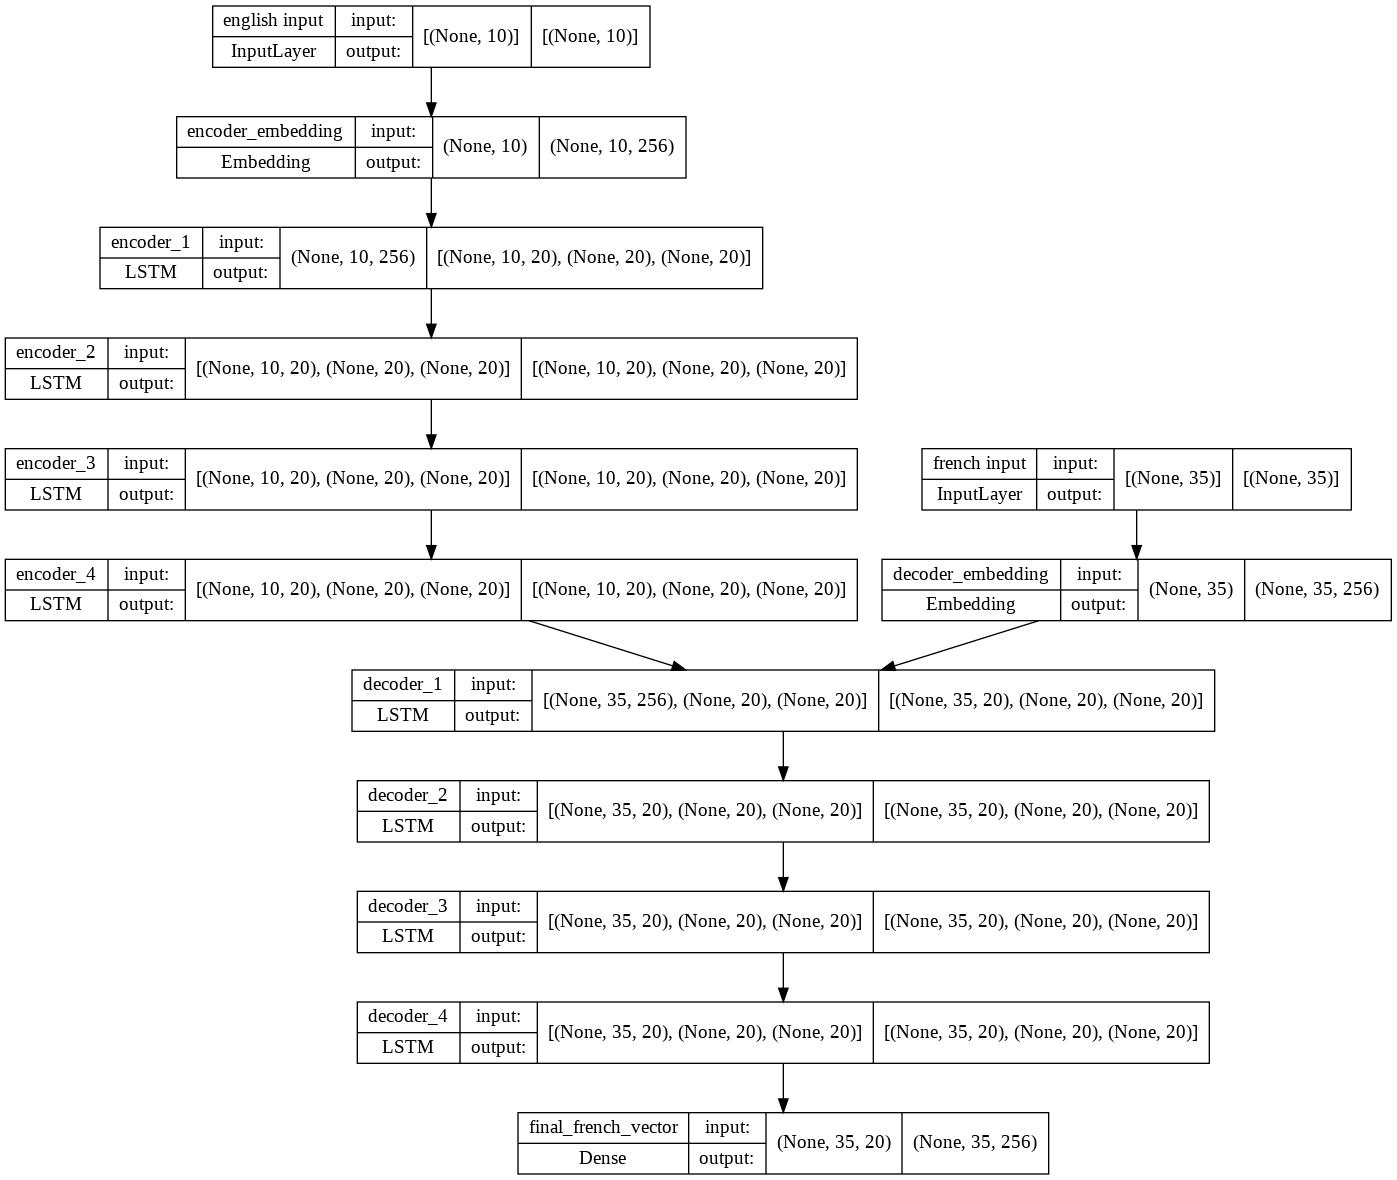

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)